In [336]:
!pip install shapely pyproj pandas progress_tracker

In [338]:
import os
import re
import json
from functools import partial

from shapely.geometry import Polygon
from shapely.ops import transform
import pyproj
from pyproj import CRS
import pandas as pd
from progress_tracker import track_progress

## Projection

The GeoJSON files have coordinates expressed in the WGS84 standard. This means that area would be calculated in degrees squared, which is not that useful for our purposes (or is it?).

We need to set up a conversion from WGS84 (EPSG:4326) to OSGB36 (EPSG:27700) for later use.

In [186]:
proj_from = CRS.from_epsg(4326) # EPSG 4326 is WGS84
proj_to = CRS.from_epsg(27700)  # EPSG 27700 is OSGB
proj = partial(pyproj.transform, proj_from, proj_to)

In [346]:
data_dir = 'data/NorthernIsochrones'
files = [f for f in os.listdir(data_dir) if re.match('.*CAR.*15minutes\.geojson', f)]

In [369]:
df = pd.DataFrame(data = { 'msoa': [], 'mode': [], 'time': [], 'area': [] })

for filename in track_progress(files, every_n_records=25):
    # print(".", end='')
    _, _, mode, _, msoa, _, _, _, _, time, *rest = re.split('[\._]', filename)

    with open(os.path.join(data_dir, filename)) as file:
        data = json.loads(file.read())

    def make_polygon(c):
        shell, *holes = c
        return Polygon(shell, holes)

    if data['type'] == 'Polygon':
        isochrone = make_polygon(data['coordinates'])

    elif data['type'] == 'MultiPolygon':
        isochrone = MultiPolygon([make_polygon(c) for c in data['coordinates']])

    area = transform(proj, isochrone).area
    # area = isochrone.area

    df.loc[len(df.index)] = [msoa, mode, time, area]

25/1943 (1.2866700977869274%) in 0:00:07.484443 (Time left: 0:09:34.206467)
50/1943 (2.573340195573855%) in 0:00:18.686168 (Time left: 0:11:47.458320)
75/1943 (3.860010293360782%) in 0:00:28.013428 (Time left: 0:11:37.721113)
100/1943 (5.14668039114771%) in 0:00:31.749641 (Time left: 0:09:45.145884)
125/1943 (6.433350488934638%) in 0:00:43.345159 (Time left: 0:10:30.411992)
150/1943 (7.720020586721564%) in 0:00:51.701628 (Time left: 0:10:18.006793)
175/1943 (9.006690684508492%) in 0:01:04.083652 (Time left: 0:10:47.427981)
200/1943 (10.29336078229542%) in 0:01:13.457056 (Time left: 0:10:40.178243)
225/1943 (11.580030880082347%) in 0:01:20.949301 (Time left: 0:10:18.092885)
250/1943 (12.866700977869275%) in 0:01:30.428815 (Time left: 0:10:12.383935)
275/1943 (14.153371075656201%) in 0:01:39.880540 (Time left: 0:10:05.820875)
300/1943 (15.440041173443127%) in 0:01:52.720323 (Time left: 0:10:17.331636)
325/1943 (16.72671127123006%) in 0:02:01.907452 (Time left: 0:10:06.911561)
350/1943 (1

In [348]:
with open('accessibility_index.csv', 'w') as csv:
    csv.write(df.sort_values(by=['msoa']).to_csv(index=False))

<AxesSubplot:ylabel='Density'>

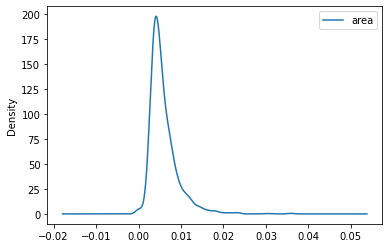

In [368]:
df.sort_values(by=['area'], ignore_index=True).plot.kde(y=['area'])

In [333]:
df

,msoa,mode,time,area_m2,area_deg2
0,E02000984,CAR,15minutes,1.030560e+08,0.002646
1,E02000985,CAR,15minutes,1.081036e+08,0.002777
2,E02000986,CAR,15minutes,1.161788e+08,0.002985
3,E02000987,CAR,15minutes,2.047361e+08,0.005264
4,E02000988,CAR,15minutes,1.776587e+08,0.004568
...,...,...,...,...,...
95,E02001082,CAR,15minutes,1.316167e+08,0.003411
96,E02001083,CAR,15minutes,1.593627e+08,0.004132
97,E02001084,CAR,15minutes,1.386254e+08,0.003592
98,E02001085,CAR,15minutes,1.423728e+08,0.003690
